In this notebook, we will do data aggregation.

The logic we need to build is: Grouping by date by combining all sales that happened on 2017-05-15, sum the revenue, average the sentiment, and count the reviews. We will also fill missing dates

Original Transaction Count: 110840
Final Daily Series Count: 714 days


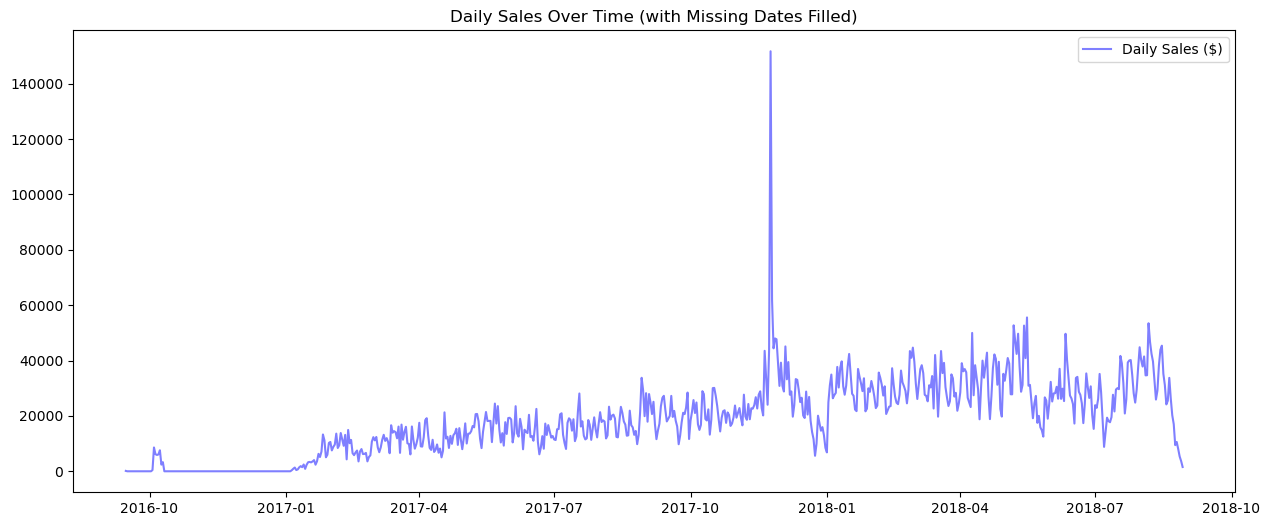

,ds,y,sentiment_avg,sales_volume
0,2016-09-15,134.97,1.0,3.0
1,2016-09-16,0.00,3.0,0.0
2,2016-09-17,0.00,3.0,0.0
3,2016-09-18,0.00,3.0,0.0
4,2016-09-19,0.00,3.0,0.0


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

#setting up the path
PROCESSED_PATH = os.path.join("..", "data", "processed")
INPUT_FILE = os.path.join(PROCESSED_PATH, "transactions_with_sentiment.parquet")

#loading the sentiment data
df = pd.read_parquet(INPUT_FILE)

#we need to ensure date is strictly datetime
df['date'] = df['order_purchase_timestamp'].dt.normalize()

print(f"Original Transaction Count: {len(df)}")

# 3. The Aggregation Logic (The 'Group By')
# We aggregate by Day to create a Daily Time Series.
daily_data = df.groupby('date').agg({
    'price': 'sum',                # Total Sales ($)
    'sentiment_score': 'mean',     # Average Sentiment (Quality)
    'order_id': 'count'            # Total Transactions (Volume/Hype)
}).reset_index()

# Rename columns for clarity
daily_data.columns = ['ds', 'y', 'sentiment_avg', 'sales_volume']
# 'ds' (Date Stamp) and 'y' (Target) are required names for Prophet later.

# 4. Handling Missing Dates (Crucial for LSTM)
# Real-world data has gaps. If no sales happened, the row is missing.
# We must re-index to include every single day from start to finish.
full_date_range = pd.date_range(start=daily_data['ds'].min(), end=daily_data['ds'].max(), freq='D')

# Reindex and fill with 0 (No sales = 0 revenue, Neutral sentiment)
daily_data = daily_data.set_index('ds').reindex(full_date_range).reset_index()
daily_data = daily_data.rename(columns={'index': 'ds'})

# Fill NaN values
daily_data['y'] = daily_data['y'].fillna(0)              # 0 Sales
daily_data['sales_volume'] = daily_data['sales_volume'].fillna(0) # 0 Orders
daily_data['sentiment_avg'] = daily_data['sentiment_avg'].fillna(3) # Neutral Sentiment (3) if no reviews

print(f"Final Daily Series Count: {len(daily_data)} days")

# 5. Save the 'Gold' Table
daily_data.to_csv(os.path.join(PROCESSED_PATH, "daily_sales_sentiment.csv"), index=False)

# 6. Visualization Check
# Let's see what our data looks like!
plt.figure(figsize=(15, 6))
plt.plot(daily_data['ds'], daily_data['y'], label='Daily Sales ($)', color='blue', alpha=0.5)
plt.title("Daily Sales Over Time (with Missing Dates Filled)")
plt.legend()
plt.show()

daily_data.head()

We can see that we have 714 days of continuous data which is like 2 years of daily records. This is sufficient data for us to train LSTM. Before we move there, we need to prove that there is a relationship between sentiment and sales. If there is no correlation then LSTM won't work.

We will create a Dual-Axis Plot to visualize this.